# Getting Started : Optimal Transport Between Two Datasets

This tutorial covers the most basic use of the `ott` toolbox:

- Compute the optimal transport between two point clouds using the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm. 
- Use the seamless integration with `jax` to differentiate through this operation.

## Imports and toy data definition

`ott` is built on top of `jax`, so we use `jax` to define all the variables of the problem.

In [1]:
import jax
import jax.numpy as jnp

We also import `matplotlib` to plot the results.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

We define a toy function and use it to generate two datasets of points, `x` and `y`:

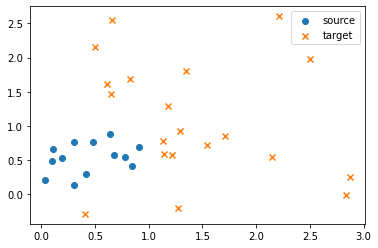

In [3]:
def create_points(rng, n_samples_source, n_samples_target, n_features):
    rngs = jax.random.split(rng, 2)
    x = jax.random.uniform(rngs[1], (n_samples_source, n_features))
    y = jax.random.normal(rngs[0], (n_samples_target, n_features)) + 1.0
    return x, y


rng = jax.random.PRNGKey(0)
n_samples_source, n_samples_target, n_features = 13, 20, 2
x, y = create_points(rng, n_samples_source, n_samples_target, n_features)

plt.scatter(x[:, 0], x[:, 1], label="source")
plt.scatter(y[:, 0], y[:, 1], label="target", marker="x")
plt.legend()

## Optimal transport with OTT

We will now use `ott` to compute the optimal transport between `x` and `y`. To do so, we first create a `geometry` object that defines the geometry between the two point clouds:

In [4]:
from ott.geometry import pointcloud

geometry = pointcloud.PointCloud(x, y)

`geometry` contains the two datasets `x` and `y`, as well as a `cost_fn` that is a way to measure distances between points. Here, we use the default settings, so the `cost_fn` is {class}`~ott.geometry.costs.SqEuclidean`, the standard squared Euclidean distance.

In order to compute the optimal transport corresponding to this `geometry`, we use the Sinkhorn algorithm. The Sinkhorn algorithm has an hyperparameter `epsilon` that controls the amount of regularization. It is stored in `geometry`, and by default it is 1/20th of the mean cost value.

In [5]:
from ott.solvers.linear import sinkhorn

ot = sinkhorn.solve(geometry)

As a small note: the computations here are *jitted*, meaning that the second time the solver is run it will be much faster:

In [6]:
ot = sinkhorn.solve(geometry)

This object `ot` contains all the information about the solution of the optimal transport problems, including the transport plan matrix that indicates how much of the mass of the point `x[i]` is moved towards `y[j]`.

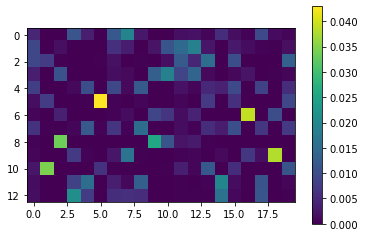

In [7]:
plt.imshow(ot.matrix)
plt.colorbar()

## Seamless integration in JAX automatic differentiation pipelines

We finish this quick tour by illustrating one of the most interesting feature of `ott`: it can be plugged easily into differentiable pipelines built in `jax`, like neural networks.

We demonstrate this by differentiating the loss of optimal transport with respect to the input dataset.

To do so, we simply define a function that takes `x` as input and outputs the loss:

In [8]:
def cost_function(x):
    geometry = pointcloud.PointCloud(x, y)
    ot = sinkhorn.solve(geometry)
    return ot.reg_ot_cost


cost_function(x)

DeviceArray(2.155828, dtype=float32)

The gradient of this function is obtained as usual with `jax`:

In [9]:
gradient_function = jax.grad(cost_function)
grad_x = gradient_function(x)

This gradient defines a direction for each sample in `x`, and following the opposite of this direction leads to a decrease in the cost: it pushes `x` closer to `y`.

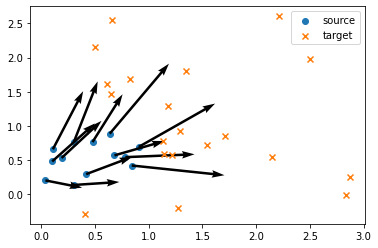

In [10]:
plt.scatter(x[:, 0], x[:, 1], label="source")
plt.quiver(x[:, 0], x[:, 1], -grad_x[:, 0], -grad_x[:, 1], scale=1)
plt.scatter(y[:, 0], y[:, 1], label="target", marker="x")
plt.legend()

For instance, this gradient can be used to update the dataset `x` to make it go towards `y`:

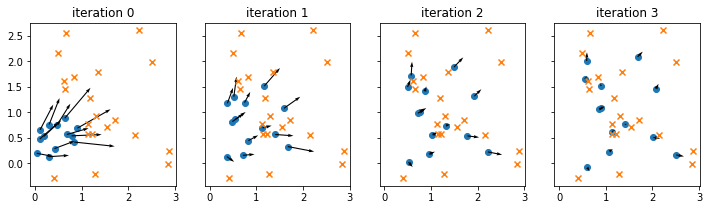

In [11]:
step_size = 3.0

f, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(12, 3))
for iteration, axe in enumerate(axes):
    grad_x = gradient_function(x)
    axe.scatter(x[:, 0], x[:, 1], label=f"source")
    axe.quiver(x[:, 0], x[:, 1], -grad_x[:, 0], -grad_x[:, 1], scale=1)
    axe.scatter(y[:, 0], y[:, 1], label="target", marker="x")
    axe.set_title(f"iteration {iteration}")
    x -= step_size * grad_x

# Going further

This tutorial gave you a glimpse of the most basic features of `OTT` and how they integrate with `jax`.
`OTT` also proposes many other functionalities including extensions of the base optimal transport problem like
- Unbalanced optimal transport to compare distributions of different masses,
- Gromov-Wasserstein distances to compare distributions defined on incomparable spaces,

but also numerical tricks to make the problem scale to large datasets like Low-rank Sinkhorn that uses a low-rank approximation of the cost matrix, or tools that are derived from optimal transport like
- Computing the average of distributions using Wasserstein barycenters
- Having an extension of the sorting operation that is differentiable

